# Time Series data Classification

## Problem Statement: 

Your first task will be regarding Human Action Recognition (HAR) using Accelerometric and Gyroscopic dataset. This is a Digital Phenotyping task. Your assignment is to use Machine Learning/Statistical tools to recognise between two different actions - Walking and Jogging - using Kaggle's MotionSense Dataset.

## Approach:

1. read data
2. exploratory data analysis & visualize data 
3. convert to time series
4. perform ordinary least squares
5. a. if r-squared higher than 0.5, then no need of new features
5. b. if r-squared lower than 0.5, add more features
5. c. if r-squared lower than 0.6 then some problem with data or approach.
6. perform decomposition of model
7. observe seasonality between walk and run. (act = 1 or 0)
8. convert data to to period of time based on observation 
9. again perform ols
9. a. if r-squared improves & adjusted r-square is close put the above features into a fully connected neural network
9. b. if r-squared improves & adjusted r-squared is far from the above features then perform feature reduction or dimensionality reduction techniques 
9. c. if r-squared does not improve change the time period or change the approach.

Machine Learning concepts covered:
1. Supervised Learning (OLS, Decomposition of model into Seasonality, Level, Trend)
2. Unsupervised Learning (Fully Connected Neural Network)

In [448]:
import numpy as np
import pandas as pd

def get_ds_infos():
    """
    Read the file includes data subject information.
    
    Data Columns:
    0: code [1-24]
    1: weight [kg]
    2: height [cm]
    3: age [years]
    4: gender [0:Female, 1:Male]
    
    Returns:
        A pandas DataFrame that contains inforamtion about data subjects' attributes 
    """ 

    dss = pd.read_csv("data_subjects_info.csv")
    print("[INFO] -- Data subjects' information is imported.")
    
    return dss

def set_data_types(data_types=["userAcceleration"]):
    """
    Select the sensors and the mode to shape the final dataset.
    
    Args:
        data_types: A list of sensor data type from this list: [attitude, gravity, rotationRate, userAcceleration] 

    Returns:
        It returns a list of columns to use for creating time-series from files.
    """
    dt_list = []
    for t in data_types:
        if t != "attitude":
            dt_list.append([t+".x",t+".y",t+".z"])
        else:
            dt_list.append([t+".roll", t+".pitch", t+".yaw"])

    return dt_list


def creat_time_series(dt_list, act_labels, trial_codes, mode="mag", labeled=True):
    """
    Args:
        dt_list: A list of columns that shows the type of data we want.
        act_labels: list of activites
        trial_codes: list of trials
        mode: It can be "raw" which means you want raw data
        for every dimention of each data type,
        [attitude(roll, pitch, yaw); gravity(x, y, z); rotationRate(x, y, z); userAcceleration(x,y,z)].
        or it can be "mag" which means you only want the magnitude for each data type: (x^2+y^2+z^2)^(1/2)
        labeled: True, if we want a labeld dataset. False, if we only want sensor values.

    Returns:
        It returns a time-series of sensor data.
    
    """
    num_data_cols = len(dt_list) if mode == "mag" else len(dt_list*3)

    if labeled:
        dataset = np.zeros((0,num_data_cols+7)) # "7" --> [act, code, weight, height, age, gender, trial] 
    else:
        dataset = np.zeros((0,num_data_cols))
        
    ds_list = get_ds_infos()
    
    print("[INFO] -- Creating Time-Series")
    for sub_id in ds_list["code"]:
        for act_id, act in enumerate(act_labels):
            for trial in trial_codes[act_id]:
                fname = 'A_DeviceMotion_data/'+act+'_'+str(trial)+'/sub_'+str(int(sub_id))+'.csv'
                raw_data = pd.read_csv(fname)
                raw_data = raw_data.drop(['Unnamed: 0'], axis=1)
                vals = np.zeros((len(raw_data), num_data_cols))
                for x_id, axes in enumerate(dt_list):
                    if mode == "mag":
                        vals[:,x_id] = (raw_data[axes]**2).sum(axis=1)**0.5        
                    else:
                        vals[:,x_id*3:(x_id+1)*3] = raw_data[axes].values
                    vals = vals[:,:num_data_cols]
                if labeled:
                    lbls = np.array([[act_id,
                            sub_id-1,
                            ds_list["weight"][sub_id-1],
                            ds_list["height"][sub_id-1],
                            ds_list["age"][sub_id-1],
                            ds_list["gender"][sub_id-1],
                            trial          
                           ]]*len(raw_data))
                    vals = np.concatenate((vals, lbls), axis=1)
                dataset = np.append(dataset,vals, axis=0)
    cols = []
    for axes in dt_list:
        if mode == "raw":
            cols += axes
        else:
            cols += [str(axes[0][:-2])]
            
    if labeled:
        cols += ["act", "id", "weight", "height", "age", "gender", "trial"]
    
    dataset = pd.DataFrame(data=dataset, columns=cols)
    return dataset
#________________________________


ACT_LABELS = ["dws","ups", "wlk", "jog", "std", "sit"]
TRIAL_CODES = {
    ACT_LABELS[0]:[1,2,11],
    ACT_LABELS[1]:[3,4,12],
    ACT_LABELS[2]:[7,8,15],
    ACT_LABELS[3]:[9,16],
    ACT_LABELS[4]:[6,14],
    ACT_LABELS[5]:[5,13]
}

## Here we set parameter to build labeld time-series from dataset of "(A)DeviceMotion_data"
## attitude(roll, pitch, yaw); gravity(x, y, z); rotationRate(x, y, z); userAcceleration(x,y,z)
sdt = ["attitude", "userAcceleration",'gravity','rotationRate']
print("[INFO] -- Selected sensor data types: "+str(sdt))    
act_labels = ACT_LABELS [2:4]
print("[INFO] -- Selected activites: "+str(act_labels))    
trial_codes = [TRIAL_CODES[act] for act in act_labels]
dt_list = set_data_types(sdt)
dataset = creat_time_series(dt_list, act_labels, trial_codes, mode="mag", labeled=True)
print("[INFO] -- Shape of time-Series dataset:"+str(dataset.shape))    
dataset = dataset.rename(columns={'attitude.ro': 'attitude'})
dataset.head()

[INFO] -- Selected sensor data types: ['attitude', 'userAcceleration', 'gravity', 'rotationRate']
[INFO] -- Selected activites: ['wlk', 'jog']
[INFO] -- Data subjects' information is imported.
[INFO] -- Creating Time-Series
[INFO] -- Shape of time-Series dataset:(478519, 11)


,attitude,userAcceleration,gravity,rotationRate,act,id,weight,height,age,gender,trial
0,3.418486,0.436055,0.999999,1.064586,0.0,0.0,102.0,188.0,46.0,1.0,7.0
1,3.481157,0.382447,1.000000,2.382086,0.0,0.0,102.0,188.0,46.0,1.0,7.0
2,3.589431,0.321885,1.000000,1.721918,0.0,0.0,102.0,188.0,46.0,1.0,7.0
3,3.728624,0.238383,1.000000,1.454360,0.0,0.0,102.0,188.0,46.0,1.0,7.0
4,3.854841,0.245271,1.000000,1.407849,0.0,0.0,102.0,188.0,46.0,1.0,7.0


## EDA and Visualization of user demographics

In [449]:
import seaborn as sns
import matplotlib.pyplot as plt


/Users/himanshu.ghadigaonkar/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


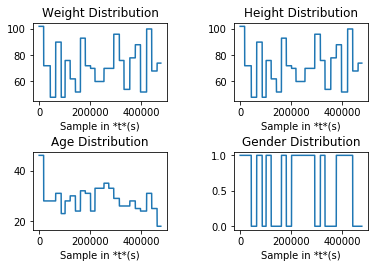

In [450]:
fig,a =  plt.subplots(2,2)
#plt.figure(figsize=(10,10))

plt.tight_layout(pad=3.0)
a[0][0].set_title('Weight Distribution')
a[0][0].set_xlabel('Sample in *t*(s)')
a[0][0].plot(dataset.index,dataset.weight)
a[0][1].set_title('Height Distribution')
a[0][1].set_xlabel('Sample in *t*(s)')
a[0][1].plot(dataset.index,dataset.weight)
a[1][0].set_title('Age Distribution')
a[1][0].set_xlabel('Sample in *t*(s)')
a[1][0].plot(dataset.index,dataset.age)
a[1][1].set_title('Gender Distribution')
a[1][1].set_xlabel('Sample in *t*(s)')
a[1][1].plot(dataset.index,dataset.gender)
fig.show()


In [451]:
dataset.columns

Index(['attitude', 'userAcceleration', 'gravity', 'rotationRate', 'act', 'id',
       'weight', 'height', 'age', 'gender', 'trial'],
      dtype='object')

In [452]:
dataset.describe()

,attitude,userAcceleration,gravity,rotationRate,act,id,weight,height,age,gender,trial
count,478519.000000,478519.000000,478519.000000,478519.000000,478519.000000,478519.000000,478519.000000,478519.000000,478519.000000,478519.000000,478519.000000
mean,2.341833,0.902748,0.999994,2.443426,0.280513,11.475321,72.120766,173.973046,28.780071,0.581900,9.341259
std,0.901365,0.710725,0.000006,1.529032,0.449251,6.964910,15.839669,8.706898,5.016864,0.493247,3.071473
min,0.546166,0.005620,0.999953,0.018739,0.000000,0.000000,48.000000,161.000000,18.000000,0.000000,7.000000
25%,1.527387,0.438972,0.999991,1.358948,0.000000,5.000000,60.000000,164.000000,25.000000,0.000000,7.000000
50%,2.249652,0.716935,0.999995,2.131668,0.000000,11.000000,72.000000,175.000000,28.000000,1.000000,8.000000
75%,3.079735,1.137232,0.999999,3.157439,1.000000,18.000000,88.000000,180.000000,31.000000,1.000000,9.000000
max,4.684841,10.113313,1.000001,21.968012,1.000000,23.000000,102.000000,190.000000,46.000000,1.000000,16.000000


### Meaning of different datapoints:
#### Input var: attitude, userAcceleration, gravity, rotationRate, weight, height, age, gender
#### Output var: act (0: Walking, 1: Running)


## Store first candidate tests in 'first'

In [453]:
is_id = dataset['id'] == 0
first = dataset[is_id]

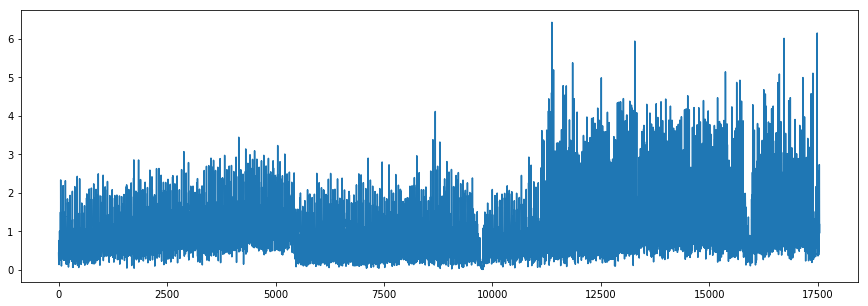

In [454]:
plt.figure(figsize=(15,5))
plt.plot(first['userAcceleration'])
plt.show()

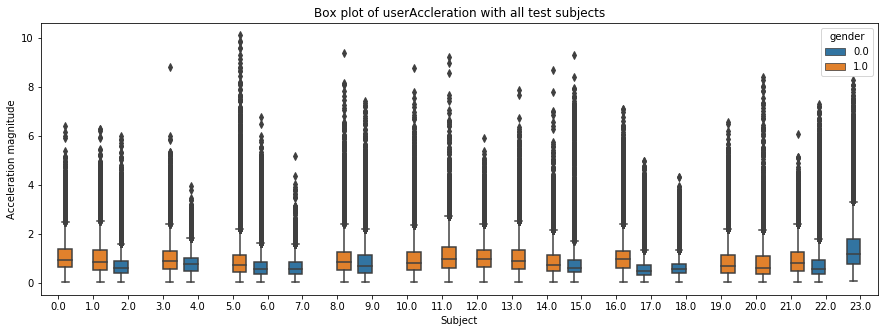

In [469]:
plt.figure(figsize=(15,5))
ax = sns.boxplot(x='id', y='userAcceleration', hue='gender', data = dataset)
plt.title('Box plot of userAccleration with all test subjects')
plt.xlabel('Subject')
plt.ylabel('Acceleration magnitude')
plt.show()

In [456]:
import datetime

In [457]:
time_stamp = pd.date_range(start='1/1/2020', periods=len(dataset.index), freq= 's')
dataset.set_index(time_stamp, inplace=True)

In [458]:
dataset.set_index(time_stamp, inplace=True)

In [459]:
dataset.head()

,attitude,userAcceleration,gravity,rotationRate,act,id,weight,height,age,gender,trial
2020-01-01 00:00:00,3.418486,0.436055,0.999999,1.064586,0.0,0.0,102.0,188.0,46.0,1.0,7.0
2020-01-01 00:00:01,3.481157,0.382447,1.000000,2.382086,0.0,0.0,102.0,188.0,46.0,1.0,7.0
2020-01-01 00:00:02,3.589431,0.321885,1.000000,1.721918,0.0,0.0,102.0,188.0,46.0,1.0,7.0
2020-01-01 00:00:03,3.728624,0.238383,1.000000,1.454360,0.0,0.0,102.0,188.0,46.0,1.0,7.0
2020-01-01 00:00:04,3.854841,0.245271,1.000000,1.407849,0.0,0.0,102.0,188.0,46.0,1.0,7.0


## Perform OLS

Seperate Level Trend and Seasonality and Noise

In [460]:
import statsmodels.api as sm
import pandas
from patsy import dmatrices

In [461]:
vars = ['attitude', 'userAcceleration', 'gravity', 'rotationRate', 'act']
df = dataset[vars]
df.head()

,attitude,userAcceleration,gravity,rotationRate,act
2020-01-01 00:00:00,3.418486,0.436055,0.999999,1.064586,0.0
2020-01-01 00:00:01,3.481157,0.382447,1.000000,2.382086,0.0
2020-01-01 00:00:02,3.589431,0.321885,1.000000,1.721918,0.0
2020-01-01 00:00:03,3.728624,0.238383,1.000000,1.454360,0.0
2020-01-01 00:00:04,3.854841,0.245271,1.000000,1.407849,0.0


In [462]:
X = df.drop("act", axis=1)
y = df['act']

## Model fit and summary

Fitting a model in statsmodels typically involves 3 easy steps:

1. Use the model class to describe the model

2. Fit the model using a class method

3. Inspect the results using a summary method

For OLS, this is achieved by:

In [463]:
mod = sm.OLS(y, X)    # Describe model

res = mod.fit()       # Fit model

print(res.summary())   # Summarize model

                            OLS Regression Results                            
Dep. Variable:                    act   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                 1.160e+05
Date:                Wed, 10 Jun 2020   Prob (F-statistic):               0.00
Time:                        15:17:42   Log-Likelihood:            -2.1270e+05
No. Observations:              478519   AIC:                         4.254e+05
Df Residuals:                  478515   BIC:                         4.255e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
attitude             0.0792      0.001  

In [464]:
print("R-squared: ",res.rsquared)


R-squared:  0.49223633497400787


### Note:
Here we were trying to classify the output(act: 0(walk) or 1(run))

The R-squared value is 0.492, this means that 49.2% of the variance in the outcome variable is explained by the model.

In [465]:
vars = ['attitude', 'userAcceleration', 'gravity', 'rotationRate', 'act', 'weight', 'height', 'age', 'gender']
df = dataset[vars]
X = df.drop("act", axis=1)
y = df['act']
mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    act   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.509
Method:                 Least Squares   F-statistic:                 6.212e+04
Date:                Wed, 10 Jun 2020   Prob (F-statistic):               0.00
Time:                        15:17:48   Log-Likelihood:            -2.0445e+05
No. Observations:              478519   AIC:                         4.089e+05
Df Residuals:                  478511   BIC:                         4.090e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
attitude             0.0836      0.001  

In [470]:
print("R-squared: ",res.rsquared)

R-squared:  0.5094549491064332


#### Note: 
Increasing the number of variables we hope to increase the R-square value.

The R-squared value is 0.509, this means that 50.9% of the variance in the outcome variable is explained by the model. 

*This is not good. *

## Seperating Seasonality and Trend from the data

*created a index with frequency as h(hour), because the statsmodels library doesn't take ms(milliseconds)*

<Figure size 1440x720 with 0 Axes>

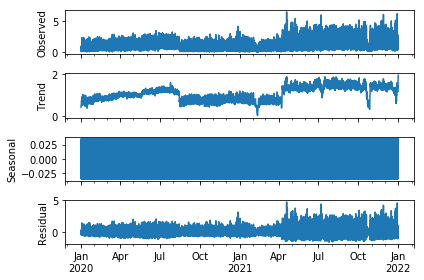

In [471]:
import datetime
from pandas import Series
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
plt.figure(figsize=(20,10))
time_stamp = pd.date_range(start='1/1/2020', periods=len(first.index), freq= 'h')
first.set_index(time_stamp, inplace=True)
series = first['userAcceleration']

result = seasonal_decompose(series, model='additive', extrapolate_trend= 5)
result.plot()
plt.show()

### Seasonality while walking

the trend will only show changes between the different *trial*s (different walks and runs)

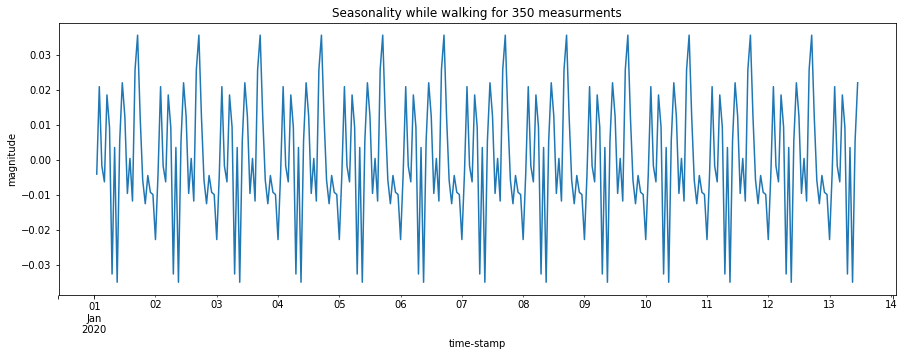

In [472]:
plt.figure(figsize=(15,5))
result.seasonal[1:300].plot()
plt.title("Seasonality while walking for 350 measurments")
plt.xlabel("time-stamp")
plt.ylabel("magnitude")
plt.show()

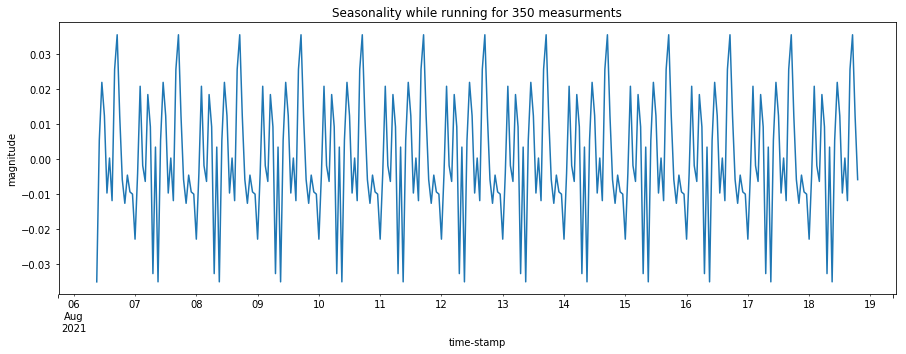

In [473]:
plt.figure(figsize=(15,5))
result.seasonal[14001:14300].plot()
plt.title("Seasonality while running for 350 measurments")
plt.xlabel("time-stamp")
plt.ylabel("magnitude")
plt.show()

## Conclusion:

taking a subset of 350 measurments and performing classification on them could work


## Reshaping Acceleration data from (478519\*1) to (100\*4785\*1) 

remainder 19

### Classification Model

In [474]:
# Import libraries
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [475]:
# Load data, reshape
arr = np.array(dataset.userAcceleration[:-19])
newarr = arr.reshape((4785,100))

s = dataset.act == 1
t = s.reset_index()
t = s.reset_index()
u = t.drop('index', axis=1)
d = u[u.index%100 == 0]


y = d.values[:-1,-1].astype(int)
X = newarr.astype(float)


we can perform train test split because we have broken the dataset into seperate 100 observations (100 \* 50 millisecond =) 5 seconds time-frames

In [476]:
# train and test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 42)

performing OLS on the *new dataset* yields 0.601

In [477]:
mod = sm.OLS(y_train, X_train)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.588
Method:                 Least Squares   F-statistic:                     48.86
Date:                Wed, 10 Jun 2020   Prob (F-statistic):               0.00
Time:                        15:22:20   Log-Likelihood:                -1071.4
No. Observations:                3349   AIC:                             2343.
Df Residuals:                    3249   BIC:                             2955.
Df Model:                         100                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0050      0.012     -0.402      0.6

## Create fully connected neural network

In [478]:
input_shape = X.shape[1]

# create model
def create_model():
    model = Sequential()
    model.add(Dense(input_shape, input_dim=input_shape, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(30,  activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    sgd = SGD(lr=0.01, momentum=0.8)
    model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
    return model

In [479]:
estimators = []
#estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_model, epochs=4, batch_size=16, verbose=0)))

pipeline = Pipeline(estimators)

kfold = StratifiedKFold(n_splits=3, shuffle=True)
results = cross_val_score(pipeline, X_train, y_train, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 94.77% (0.57%)


In [488]:
print(model.summary()) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_443 (Dense)            (None, 100)               10100     
_________________________________________________________________
dropout_90 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_444 (Dense)            (None, 30)                3030      
_________________________________________________________________
dense_445 (Dense)            (None, 1)                 31        
Total params: 13,161
Trainable params: 13,161
Non-trainable params: 0
_________________________________________________________________
None


## model for prediction

In [489]:
from keras.optimizers import SGD
from keras.losses import mean_squared_error, binary_crossentropy

model = Sequential()
model.add(Dense(input_shape, input_dim=input_shape, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(30,  activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# Compile model
sgd = SGD(lr=0.01, momentum=0.8)
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
d = model.fit(X_train, y_train, epochs=25, batch_size=16, validation_split=0.2)

[<keras.layers.core.Dense object at 0x1226716d8>, <keras.layers.core.Dropout object at 0x1226716a0>, <keras.layers.core.Dense object at 0x122671a20>, <keras.layers.core.Dense object at 0x1226771d0>]
Train on 2679 samples, validate on 670 samples
Epoch 1/25
2679/2679 [==============================] - 6s 2ms/step - loss: 0.6563 - acc: 0.6823 - val_loss: 0.6110 - val_acc: 0.7522
Epoch 2/25
2679/2679 [==============================] - 1s 358us/step - loss: 0.5775 - acc: 0.8018 - val_loss: 0.5370 - val_acc: 0.8627
Epoch 3/25
2679/2679 [==============================] - 1s 355us/step - loss: 0.5038 - acc: 0.8443 - val_loss: 0.4683 - val_acc: 0.8761
Epoch 4/25
2679/2679 [==============================] - 1s 357us/step - loss: 0.4323 - acc: 0.8828 - val_loss: 0.4175 - val_acc: 0.8358
Epoch 5/25
2679/2679 [==============================] - 1s 358us/step - loss: 0.3692 - acc: 0.8903 - val_loss: 0.3304 - val_acc: 0.9433
Epoch 6/25
2679/2679 [==============================] - 1s 384us/step - loss

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


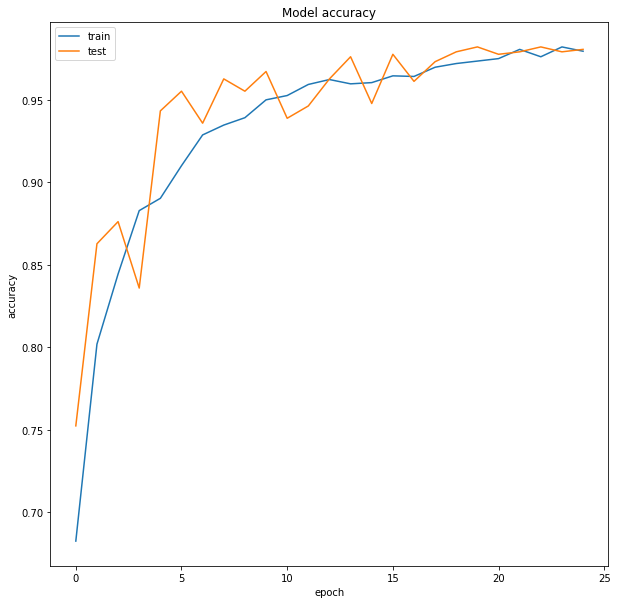

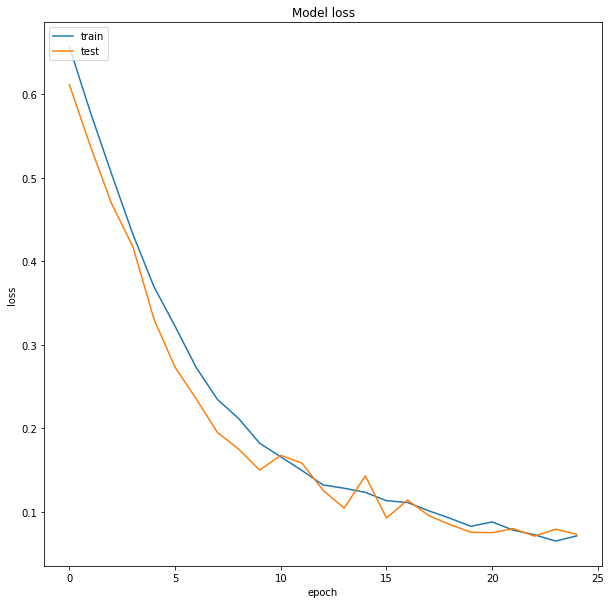

In [490]:
history = d
# summarize history for accuracy
plt.figure(figsize=(10,10))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.figure(figsize=(10,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [491]:
y_hat = model.predict_classes(X_test)

In [492]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

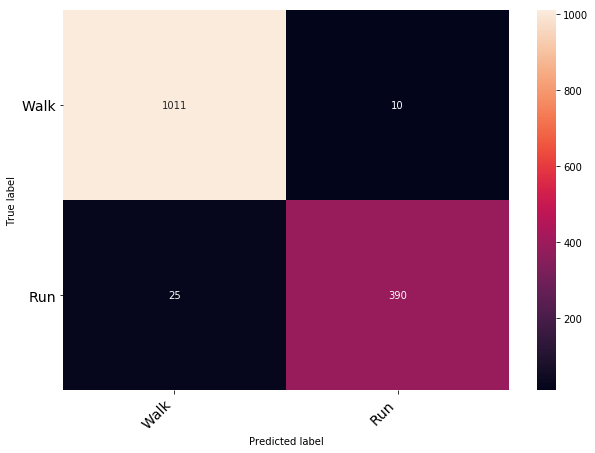

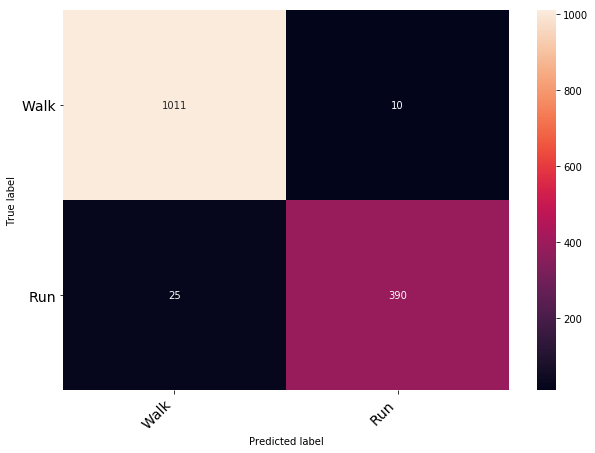

In [493]:
from sklearn.metrics import confusion_matrix
c = confusion_matrix(y_test, y_hat)
names = ['Walk','Run']
print_confusion_matrix(c,names)

In [494]:
from sklearn.metrics import r2_score,classification_report, accuracy_score, roc_curve, roc_auc_score, auc
print(classification_report(y_test, y_hat, target_names=names))
print('Accuracy Score: ',accuracy_score(y_test, y_hat))

              precision    recall  f1-score   support

        Walk       0.98      0.99      0.98      1021
         Run       0.97      0.94      0.96       415

   micro avg       0.98      0.98      0.98      1436
   macro avg       0.98      0.96      0.97      1436
weighted avg       0.98      0.98      0.98      1436

Accuracy Score:  0.9756267409470752


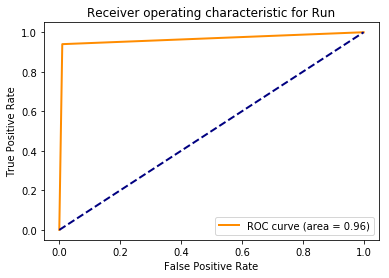

In [495]:
#plt.figure(figsize=(10,10))

fpr, tpr, _ = roc_curve(y_test, y_hat, pos_label=1)
roc_auc = auc(fpr, tpr)

lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for Run')
plt.legend(loc="lower right")


plt.show()


# Results: 

A classifier for a hand activity recognition is existing

The classifier can predict whether the user is walking or running based on the magnitude of userAcceleration data.

Start:

This model used EDA(exploratory data analysis) and OLS(ordinary Least Squares) method for classifying the output parameter and trying to determine the most important features needed in the model.

After realising Time Series Data:

After understanding that the data is a time series we treat it as a time series and extract Trend and Seasonality from the data. 

This helps us understand that seasonality can be captured when observations of a feature over a period of time are used for classification. 

For the current scenario we need to classify between two classes walk or run, hence we have taken only one variable and a period of time as 100ms.
100 ms gives us 100 classes and performing OLS, to check if approach is correct.

Now create a Sequential FCN with 1 hidden layer and 1 dropout layer. 

Put the above in a sklearn pipeline, and do strafied KFold cross validation and iterate for 3 to 5 epochs. 

The results tell us that the model in create_model function works.

Now use same model to improve validation accuracy.

Show confusion matrix and ROC curves. 

Improve model till precision accuracy and recall for walk and run are above 95%.

Conclusion:

A simple 1 hidden layer FCN model with input single variable is a good model.

Drawback:

It needs 5 seconds data. Thus we need time before we can make prediction.

The model can be improved further by adding more features. 